In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from util.load import DataLoader
from util.backtest import Backtest
from util.plot import (
    create_pairwise_scatter_plot,
    create_correlation_matrix,
    plot_backtest_results,
)
from sklearn.model_selection import TimeSeriesSplit
from warnings import filterwarnings

In [2]:
dataloader = DataLoader(data_dir="../data")
ticker = "kxhighny"
max_days = 100
df = dataloader.load_consolidated_daily_data(
    ticker, max_days=max_days, type_="polysignal"
)
df.drop(columns=["time", "ticker", "trade_id"]).head()

Loading kxhighny for 2025-03-25: 100%|██████████| 35/35 [00:00<00:00, 171.06it/s]


,time_to_strike,day_forecast_strike_dev,current_forecast_strike_dev,day_current_forecast_dev,day_wind_gusts_max,day_wind_speed_max,day_cloud_cover_max,day_cloud_cover_min,day_sunshine_duration,hour_wind_gusts,...,yes_price_sentiment_60,count_sentiment_60,yes_price_trend_60,count_agg_120,yes_price_vol_120,count_vol_120,taker_side_sentiment_120,yes_price_sentiment_120,count_sentiment_120,yes_price_trend_120
0,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
1,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
2,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
3,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4
4,86378.686,1.3,-12.1,13.4,51.8,27.5,99,0,41428.27,18.4,...,43.333,100.733,-4,1511,2.637,99.877,1.0,43.333,100.733,-4


In [22]:
df.columns.tolist()

['time',
 'trade_id',
 'ticker',
 'time_to_strike',
 'day_forecast_strike_dev',
 'current_forecast_strike_dev',
 'day_current_forecast_dev',
 'day_wind_gusts_max',
 'day_wind_speed_max',
 'day_cloud_cover_max',
 'day_cloud_cover_min',
 'day_sunshine_duration',
 'hour_wind_gusts',
 'hour_wind_speed',
 'hour_cloud_cover',
 'hour_cloud_cover_high',
 'kalshi_strike_dev',
 'polymk_strike_dev',
 'kalshi_polymk_dev',
 'kalshi_day_forecast_dev',
 'polymk_day_forecast_dev',
 'day_forecast_percipitation',
 'day_forecast_rain',
 'hour_forecast_rain',
 'yes_price',
 'no_price',
 'taker_side',
 'count',
 'shift',
 'impact',
 'result',
 'outcome',
 'count_agg_2',
 'yes_price_vol_2',
 'count_vol_2',
 'taker_side_sentiment_2',
 'yes_price_sentiment_2',
 'count_sentiment_2',
 'yes_price_trend_2',
 'count_agg_5',
 'yes_price_vol_5',
 'count_vol_5',
 'taker_side_sentiment_5',
 'yes_price_sentiment_5',
 'count_sentiment_5',
 'yes_price_trend_5',
 'count_agg_15',
 'yes_price_vol_15',
 'count_vol_15',
 'tak

In [12]:
df.groupby("shift")["outcome"].mean()

shift
-5.0    0.610330
-3.0    0.203839
-1.0    0.325065
 1.0    0.444704
 3.0    0.409883
 5.0    0.217582
Name: outcome, dtype: float64

In [16]:
df[df["time_to_strike"] > 3600 * 14].groupby("outcome")[
    ["shift", "yes_price", "count"]
].mean()

,shift,yes_price,count
outcome,,,
0,-0.140322,25.300632,27.333877
1,0.079440,41.312544,29.471662


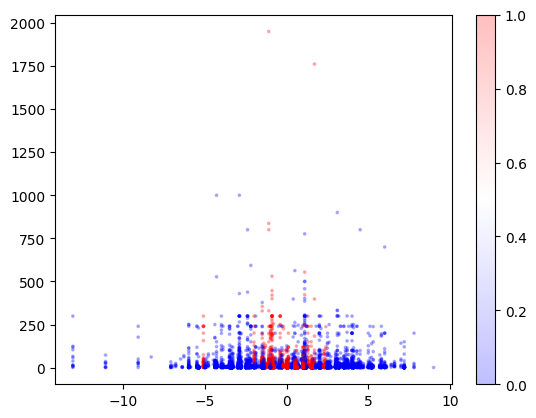

In [26]:
early_df = df[df["time_to_strike"] > 60000]
x, y = early_df["day_forecast_strike_dev"], early_df["count"]

plt.scatter(x, y, c=early_df["outcome"], cmap="bwr", alpha=0.25, s=3)
plt.colorbar()
plt.show()

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import SVC

f = [
    "time_to_strike",
    "yes_price",
    "day_forecast_strike_dev",
    "day_current_forecast_dev",
    "count",
    "polymk_strike_dev",
    "kalshi_strike_dev",
    "yes_price_trend_60",
]

scaler = RobustScaler(unit_variance=True)
scaler = QuantileTransformer(n_quantiles=100, output_distribution="uniform")

scaler = Pipeline(
    [
        ("robust_scaler", RobustScaler(unit_variance=True)),
        (
            "quantile_transformer",
            QuantileTransformer(n_quantiles=100, output_distribution="normal"),
        ),
    ]
)

pca = PCA(n_components=3)

partial_df = df[df["time_to_strike"] < 60000]

df_f = partial_df[f]
df_f = scaler.fit_transform(df_f)
df_f = pca.fit_transform(df_f)

# plt.scatter(df_f[:, 0], df_f[:, 1], c=partial_df['outcome'], cmap='bwr', alpha=0.25, s=3)
# plt.colorbar()
# plt.show()

svm = SVC(kernel="linear", C=1, gamma="auto")
svm.fit(df_f, partial_df["outcome"])

# plt.scatter(df_f[:, 0], df_f[:, 1], c=partial_df['outcome'], cmap='bwr', alpha=0.25, s=3)
# plt.colorbar()
# plt.show()
print(svm.score(df_f, partial_df["outcome"]))

0.630358546465929


In [65]:
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

pipeline = Pipeline(
    [
        ("robust_scaler", RobustScaler(unit_variance=True)),
        (
            "quantile_transformer",
            QuantileTransformer(n_quantiles=100, output_distribution="uniform"),
        ),
        (
            "stacking",
            StackingClassifier(
                estimators=[
                    #    ("gb", GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=4, subsample=0.5, min_samples_split=50, random_state=42)),
                    #    ("rf", RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)),
                    ("logistic", LogisticRegression()),
                    #    ("knn", KNeighborsClassifier(n_neighbors=10)),
                ],
            ),
        ),
    ]
)

In [63]:
excluded = ["time", "result", "impact", "ticker", "trade_id", "outcome"]
features = np.array([f for f in df.columns.tolist() if (f not in excluded)])

In [66]:
from sklearn.metrics import accuracy_score, f1_score


backtest_days = 10
dates = df["time"].dt.date.unique()
tscv = TimeSeriesSplit(n_splits=backtest_days, test_size=1)

for train_index, test_index in tscv.split(dates):
    train_data, test_data = (
        df[df["time"].dt.date.isin(dates[train_index])],
        df[df["time"].dt.date.isin(dates[test_index])],
    )
    pipeline.fit(train_data[features], train_data["outcome"])
    predictions = pipeline.predict(test_data[features])
    # proba = pipeline.predict_proba(test_data[features])[:, 1]
    acc = accuracy_score(test_data["outcome"], predictions)
    f1 = f1_score(test_data["outcome"], predictions)
    class_imbalance = test_data["outcome"].mean()
    class_imbalance = max(class_imbalance, 1 - class_imbalance)
    print(
        f"{dates[test_index][0]} - Accuracy: {acc:.3f} | F1: {f1:.3f} | Imbalance: {class_imbalance:.3f}"
    )
    print(classification_report(test_data["outcome"], predictions))

2025-04-20 - Accuracy: 0.874 | F1: 0.846 | Imbalance: 0.527
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       155
           1       1.00      0.73      0.85       139

    accuracy                           0.87       294
   macro avg       0.90      0.87      0.87       294
weighted avg       0.90      0.87      0.87       294

2025-04-21 - Accuracy: 0.733 | F1: 0.413 | Imbalance: 0.657
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       671
           1       0.83      0.27      0.41       350

    accuracy                           0.73      1021
   macro avg       0.78      0.62      0.62      1021
weighted avg       0.76      0.73      0.68      1021

2025-04-23 - Accuracy: 0.702 | F1: 0.296 | Imbalance: 0.704
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       767
           1       0.49      0.21      0.30       322

  